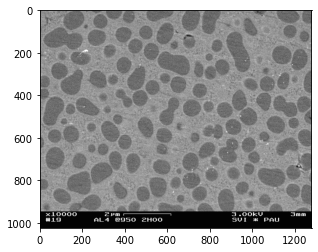

(dtype('uint8'), (1024, 1280))

In [1]:
%matplotlib inline
import imageio
from matplotlib import pyplot as plt
import numpy as np

im = imageio.imread('D:\Teaching\Pengolahan Citra Medika\Database\phase_separation.png')
plt.imshow(im, cmap='gray')
plt.show()
im.dtype, im.shape

# Removes the information bar at the bottom, in order to retain only the region of the image with the blobs of interest. 

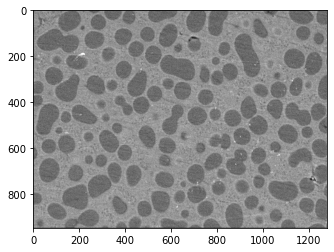

In [2]:
phase_separation = im[:947]
plt.imshow(phase_separation, cmap='gray')

Text(0.5, 1.0, 'Histogram of gray values')

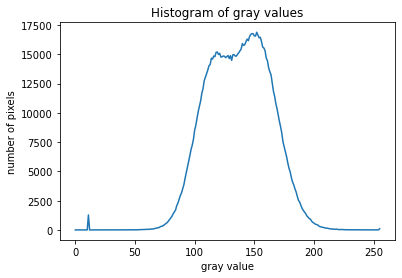

In [3]:
from skimage import exposure
import scipy.ndimage as ndi

histogram = ndi.histogram(phase_separation, min=0, max=255, bins=256)

#histogram = exposure.histogram(phase_separation)
plt.plot(histogram)
plt.xlabel('gray value')
plt.ylabel('number of pixels')
plt.title('Histogram of gray values')

# Otsu Thresholding

In [4]:
from skimage import filters

threshold = filters.threshold_otsu(phase_separation) #deteksi otomatis nilai threshold yg pas
threshold

136

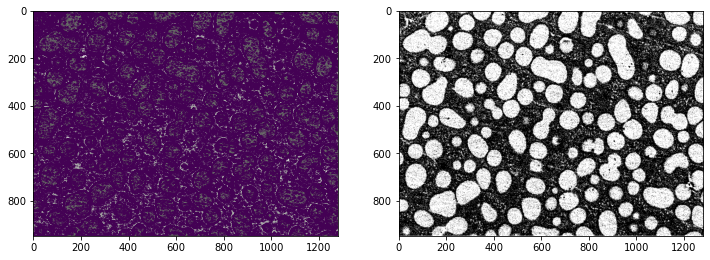

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 8))
ax[0].imshow(phase_separation, cmap='gray')
ax[0].contour(phase_separation, [threshold]) #contour pada daerah threshold
ax[1].imshow(phase_separation < threshold, cmap='gray')

# Image Denoising (Filter)

17.67220911487865


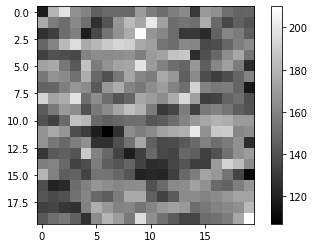

In [6]:
plt.imshow(phase_separation[390:410, 820:840], cmap='gray')
plt.colorbar()
print(phase_separation[390:410, 820:840].std())

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

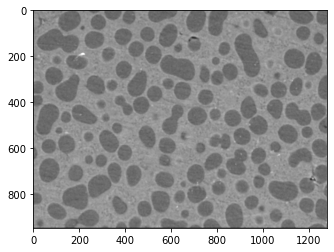

In [7]:
from skimage import filters

median_filtered = filters.median(phase_separation, np.ones((7, 7)))
plt.imshow(median_filtered, cmap='gray')

cek = np.ones((7,7))
cek

5.533660632890312


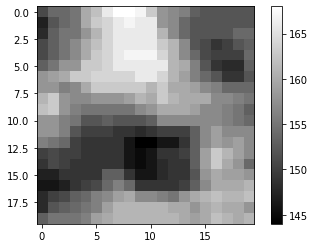

In [8]:
plt.imshow(median_filtered[390:410, 820:840], cmap='gray', 
           interpolation='nearest')
plt.colorbar()
print(median_filtered[390:410, 820:840].std())

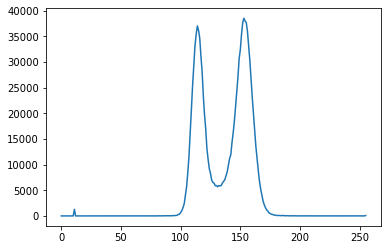

In [9]:
histo_median = ndi.histogram(median_filtered, min=0, max=255, bins=256)
plt.plot(histo_median)

# Segmentation

134

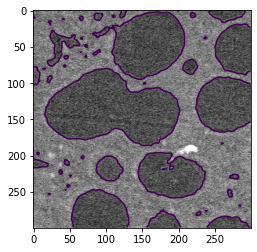

In [10]:
threshold2 = filters.threshold_otsu(median_filtered)
plt.imshow(phase_separation[:300, :300], cmap='gray')
plt.contour(median_filtered[:300, :300], [threshold2])
threshold2

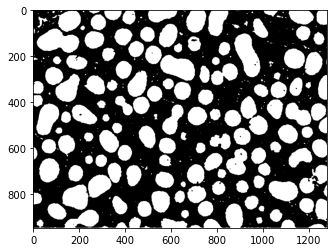

In [11]:
binary_image = median_filtered < filters.threshold_otsu(median_filtered)
plt.imshow(binary_image, cmap='gray')

# Image Cleaning: Morphological Filtering

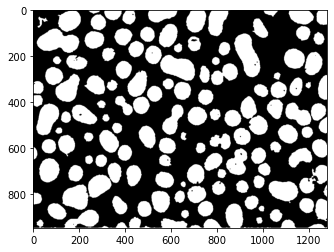

In [12]:
from skimage import morphology

#Remove small objects
only_large_blobs = morphology.remove_small_objects(binary_image, 
                                                   min_size=300)
plt.imshow(only_large_blobs, cmap='gray')

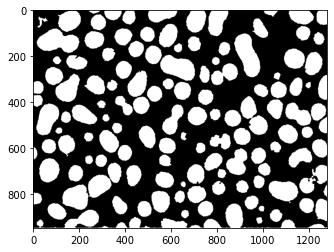

In [13]:
#Fill small holes
only_large = np.logical_not(morphology.remove_small_objects(
                                    np.logical_not(only_large_blobs), 
                                                   min_size=300))
image_segmented = only_large
plt.imshow(image_segmented, cmap='gray')

# Object Labeling

In [14]:
labels, nlabels = ndi.label(image_segmented)

label_arrays = []
#for label_num in range(1, nlabels+1):  
    
  #  label_mask = np.where(labels == label_num, 1, 0)
 #   label_arrays.append(image_segmented)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 127 separate components / objects detected.


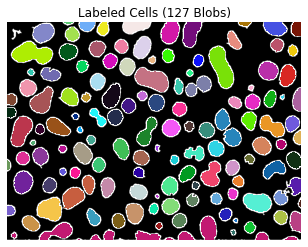

In [15]:
# Create a random colormap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(image_segmented, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Blobs)'.format(nlabels))
plt.show()

In [16]:
boxes = ndi.find_objects(labels)
for label_ind, label_coords in enumerate(boxes):
    cell = image_segmented[label_coords]
    
    # Check if the label size is too small
    if np.product(cell.shape) < 2000: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        image_segmented = np.where(labels==label_ind+1, 0, image_segmented)

# Regenerate the labels
labels, nlabels = ndi.label(image_segmented)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 0 is too small! Setting to 0.
Label 6 is too small! Setting to 0.
Label 24 is too small! Setting to 0.
Label 31 is too small! Setting to 0.
Label 32 is too small! Setting to 0.
Label 38 is too small! Setting to 0.
Label 48 is too small! Setting to 0.
Label 57 is too small! Setting to 0.
Label 67 is too small! Setting to 0.
Label 73 is too small! Setting to 0.
Label 76 is too small! Setting to 0.
Label 77 is too small! Setting to 0.
Label 86 is too small! Setting to 0.
Label 93 is too small! Setting to 0.
Label 101 is too small! Setting to 0.
Label 108 is too small! Setting to 0.
Label 110 is too small! Setting to 0.
Label 123 is too small! Setting to 0.
Label 125 is too small! Setting to 0.
Label 126 is too small! Setting to 0.
There are now 107 separate components / objects detected.


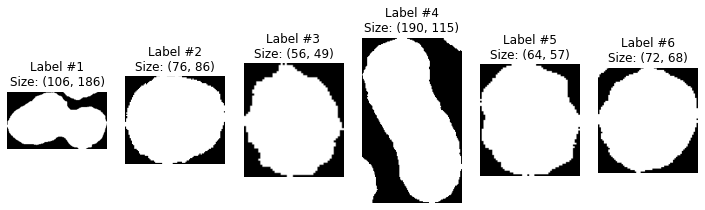

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10,6))

for ii, obj_indices in enumerate(ndi.find_objects(labels)[15:21]):
    cell = image_segmented[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize: {}'.format(ii+1, cell.shape))

plt.tight_layout()
plt.show()

# Label Image Regions with Scikit-image

In [44]:
import math
import pandas as pd
from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate


image = image_segmented

label_img = label(image)
regions = regionprops(label_img)
label_img

array([[  0,   0,   0, ...,   7,   7,   7],
       [  0,   0,   0, ...,   7,   7,   7],
       [  0,   0,   0, ...,   7,   7,   7],
       ...,
       [  0,   0,   0, ...,   0, 106, 106],
       [106,   0,   0, ..., 106, 106, 106],
       [106, 106, 106, ..., 106, 106, 106]], dtype=int64)

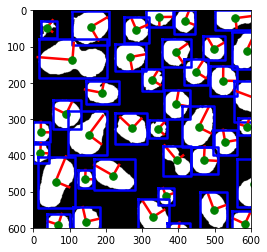

In [45]:
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)

ax.axis((0, 600, 600, 0))
plt.show()


In [46]:
props = regionprops_table(label_img, properties=('centroid',
                                                 'orientation',
                                                 'major_axis_length',
                                                 'minor_axis_length'))

In [50]:
df1=pd.DataFrame(props)
df1

,centroid-0,centroid-1,orientation,major_axis_length,minor_axis_length
0,18,347,-1.553990,77.258247,46.606973
1,29,418,-0.368851,65.880344,55.517835
2,21,557,-1.443396,134.017266,52.362783
3,45,709,-0.420632,105.895365,82.032478
4,49,800,-0.332689,128.459490,77.170088
...,...,...,...,...,...
102,862,750,-0.824487,69.199710,64.708016
103,863,485,0.231283,70.047888,60.881657
104,874,103,1.007659,87.473313,62.633778
105,917,607,-1.568759,1301.164499,95.881354


In [52]:
df1.to_excel(r'D:\Teaching\Pengolahan Citra Medika\Database\export_dataframe.xlsx',
             sheet_name='Sheet_name_1')  
